# Supernovae & Redshift
Measuring the cosmological relationship between distance and redshift is at the heart of the entire field of cosmology and allowed, among other things, the discovery of dark energy! At high redshifts, this is done with Type Ia Supernova which are standard (or better, standardizable) candles.

This is a [Nobel prize](https://www.nobelprize.org/prizes/physics/2011/riess/facts/) plot by [Riess et al](https://iopscience.iop.org/article/10.1086/300499)

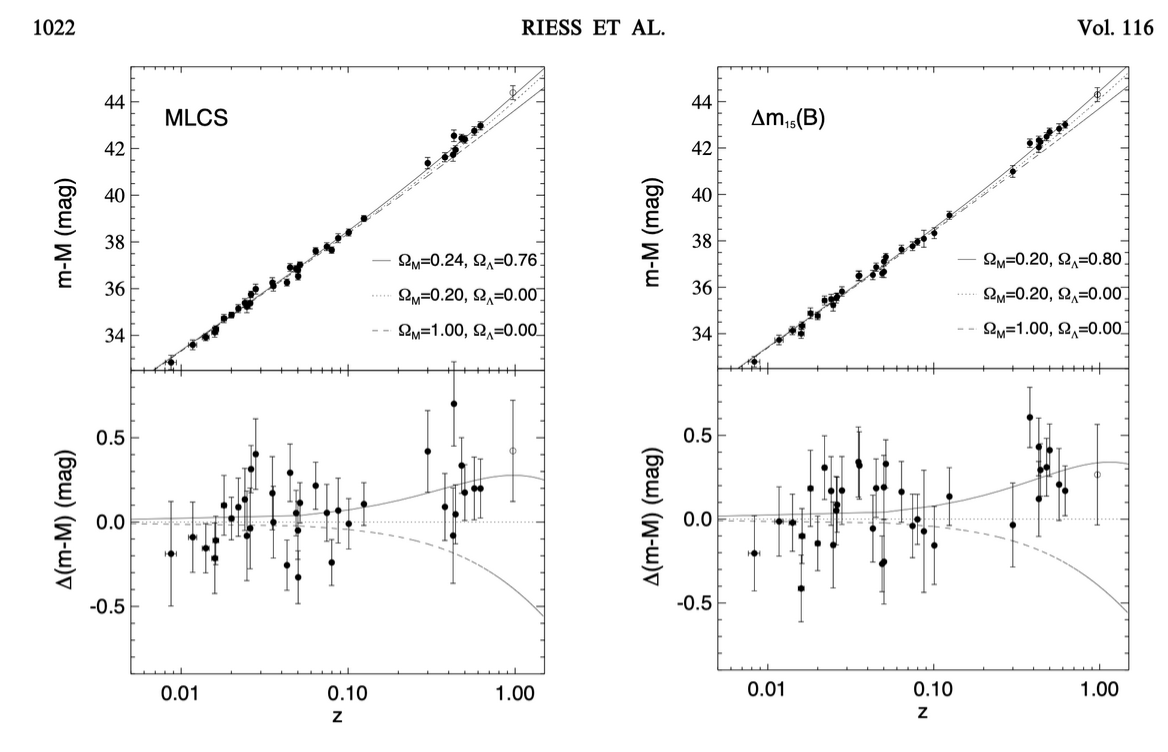

In [1]:
from IPython.display import Image, display
display(Image(filename='../../Images/SN and Redshift.png'))

Let's recall the definition of magnitude and the distance modulus (ah! the astronomers...)

$$
\mu = m-M =  5 \log_{10}\left(\frac{d_L}{\rm pc}\right) - 5
$$

Here is the Hubble diagram for Type Ia supernovae (which are standard candels). The lines show the predictions for cosmologies with varying amounts of $\Omega_m$ and $\Omega_\Lambda$. The observed points all lie above the line for a universe with zero $\Lambda$. The lower panel, with the slope caused by the inverse square law taken out, shows the difference between the predictions more clearly and shows why a model with $\Omega_\Lambda > 0$ is favored.

These are some (synthetic but realistic; see textbook) supernova data

###  Tasks

- First, explore fitting this data with the tecniques we have seen.
- Start from linear regression and polynomial regression
- For the case of  polynomial regression, just fit many of them for now.
- Let's bet based on intuition! Which fit is the best?
- In what cases are you underfitting the data?
- In what cases are you overfitting the data?
- Now split the data into training and validation sets
- Implement a cross-validation procedure
- Pick the best!
- Does it agree with our bets?

### If you have time (or later at home...)

- Repeat with Basis Function Regression and Kernel Regression
- Explore what happens when you change the number of datapoints and plot the resulting learning curves.

In [2]:
# ----------------
# AstroML packages
from astroML.datasets import generate_mu_z
from astroML.linear_model import BasisFunctionRegression
from astroML.linear_model import PolynomialRegression
from astroML.linear_model import LinearRegression
from astroML.linear_model import NadarayaWatson

# ----------------
# Astropy packages
from astropy.cosmology import FlatLambdaCDM
import astropy.units as u

# -----------------
# Scipy
from scipy.optimize import fmin_cobyla
from scipy.optimize import curve_fit
from scipy.stats import norm

# -----------------
# Sklearn
import sklearn
from sklearn.gaussian_process import GaussianProcessRegressor, kernels
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import learning_curve
from sklearn import datasets, linear_model
from sklearn.model_selection import cross_val_predict
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import PolynomialFeatures
from sklearn.model_selection import KFold

# -----------------
# Plot stuff
import numpy as np
import pylab as plt
from matplotlib import pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format='retina'

/home/ario/anaconda3/lib/python3.11/site-packages/astroML/linear_model/linear_regression_errors.py:10: UserWarning: LinearRegressionwithErrors requires PyMC3 to be installed
  warnings.warn('LinearRegressionwithErrors requires PyMC3 to be installed')


# Plot the data

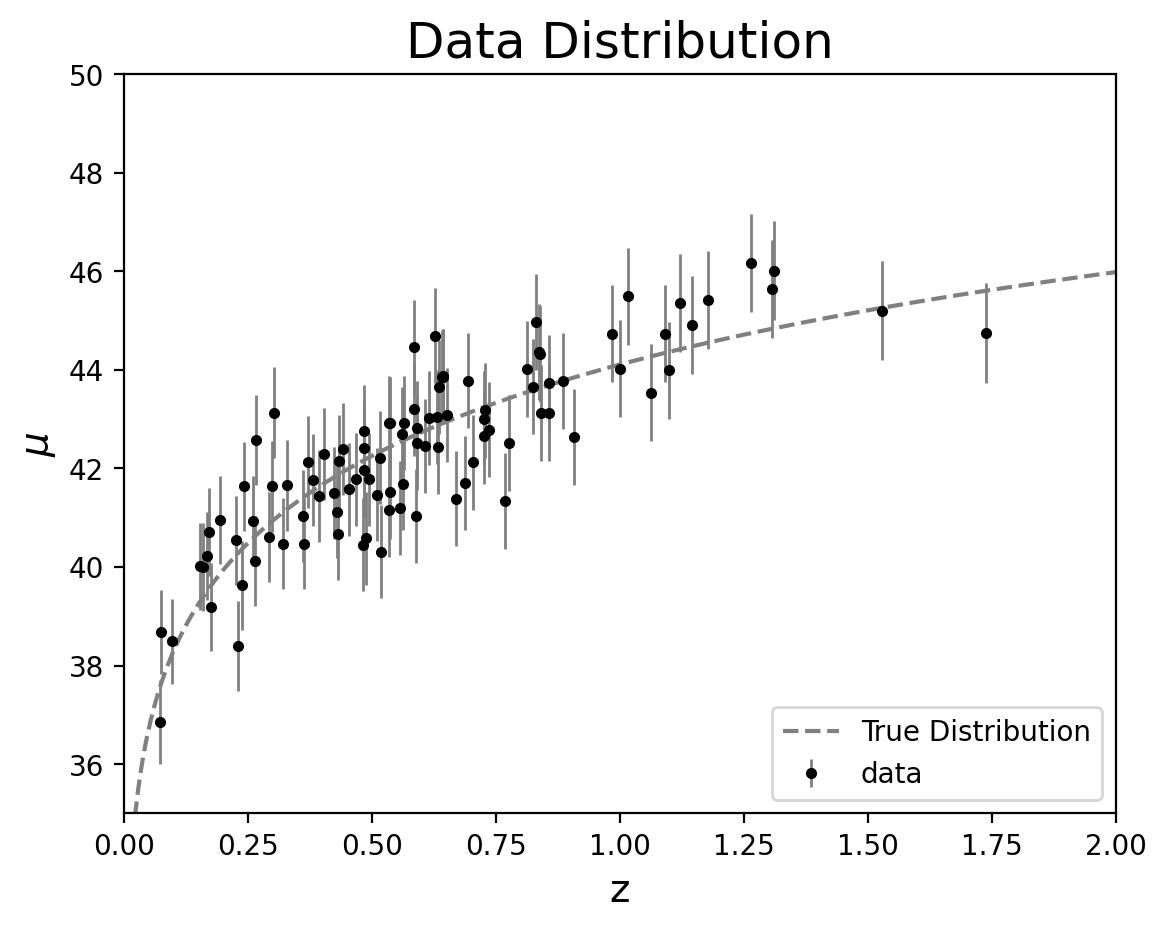

In [3]:
from astroML.datasets import generate_mu_z
z_sample, mu_sample, dmu = generate_mu_z(100, random_state=1234)

# -----------------------------------------------------------
# Real Distribution
from astropy.cosmology import LambdaCDM
cosmo = LambdaCDM(H0=71, Om0=0.27, Ode0=1-0.27)
z = np.linspace(0.01, 2, 1000)
mu_true = cosmo.distmod(z)

plt.errorbar(z_sample, mu_sample, dmu, fmt='.k', ecolor='gray', lw=1,label='data')
plt.plot(z, mu_true, color='grey', linestyle='--', label='True Distribution')
plt.xlabel('z', fontsize=14)
plt.ylabel("$\mu$", fontsize=14)
plt.title('Data Distribution', fontsize=18)
plt.legend(loc='lower right')
plt.xlim(0,2)
plt.ylim(35,50);

In [4]:
dataset = np.array((z_sample, mu_sample)).T
# print(dataset)

# Sort the dataset
dataset_sorted = dataset[dataset[:,0].argsort()]

z = np.linspace(0.01, 2, 1000)

# Linear Regression
I'll use `AstroML`, which allows also to account for heteroscedastic errors.

In [5]:
model_LR = LinearRegression()
model_LR.fit(dataset_sorted[:,0][:,None], dataset_sorted[:,1][:,None], dmu)
mu_prediction = model_LR.predict(dataset_sorted[:,0][:,None])

In [6]:
print('Coefficients')
print('----------------------')
print(f'm = {model_LR.coef_[0][0]}')
print(f'q = {model_LR.intercept_[0]}')

Coefficients
----------------------
m = 4.6421594961931305
q = 39.57112419200095


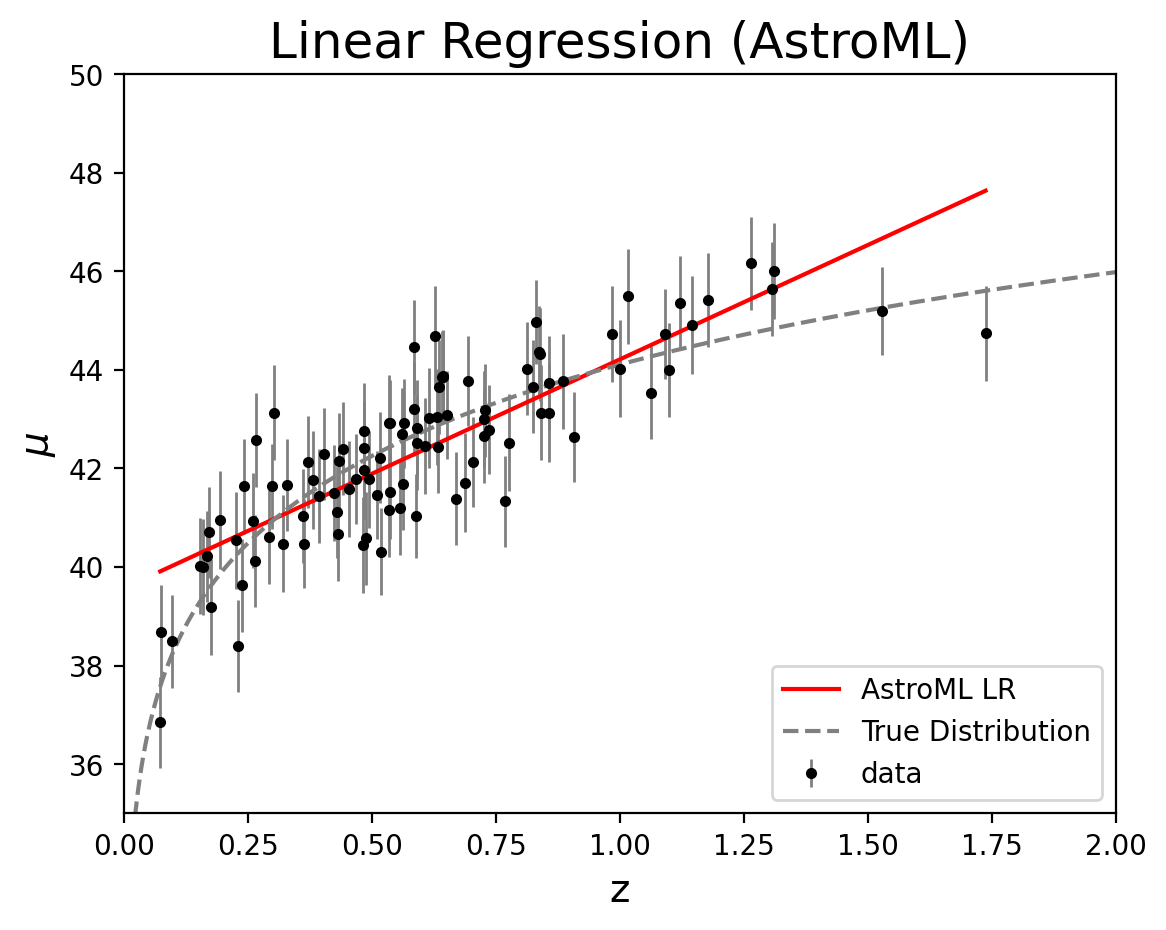

In [7]:
# Plot the data with the Linear Fitting
plt.errorbar(dataset_sorted[:,0], dataset_sorted[:,1], dmu, fmt='.k', ecolor='gray', lw=1,label='data')
plt.plot(dataset_sorted[:,0], mu_prediction, c='red', label='AstroML LR')
plt.plot(z, mu_true, color='grey', linestyle='--', label='True Distribution')
plt.xlabel("z", fontsize=14)
plt.ylabel("$\mu$", fontsize=14)
plt.title('Linear Regression (AstroML)', fontsize=18)
plt.legend(loc='lower right')
plt.xlim(0,2)
plt.ylim(35,50);

## Polynomial Regression

In [8]:
# Insert all in some dictionaries
model_PR         = {}
model_PR_coeff   = {}
mu_prediction_PR = {}
n_constraints    = {}

# I try with n-degree polynomials with n from 1 to 5
for i in range(1,6):
    degree = i
    model_PR[f'{i}'] = PolynomialRegression(degree)
    model_PR[f'{i}'].fit(dataset_sorted[:,0][:,None], dataset_sorted[:,1], dmu)
    model_PR_coeff[f'{i}'] = model_PR[f'{i}'].coef_

    mu_prediction_PR[f'{i}'] = model_PR[f'{i}'].predict(z[:,None])
    n_constraints[f'{i}']    = degree + 1

In [9]:
# ------------------------------------
# Plot a dictionary in an ordered way:
def print_coeff(dct):
    
    print("n coeff : values")
    print(" ")
    
    for n_coeff, values in dct.items():  
        
        print("{}: ({})".format(n_coeff, values))

In [10]:
print_coeff(model_PR_coeff)

n coeff : values
 
1: ([39.55329971  4.65658525])
2: ([38.42232154  8.5365867  -2.59817659])
3: ([38.46307501  8.29870416 -2.24394388 -0.14393826])
4: ([ 37.05705797  20.55669167 -32.31075065  26.85521433  -7.86510687])
5: ([ 36.12905078  31.55950786 -71.96764357  86.33101968 -46.6565537
   9.05664251])


## Plot the results of Linear Regression

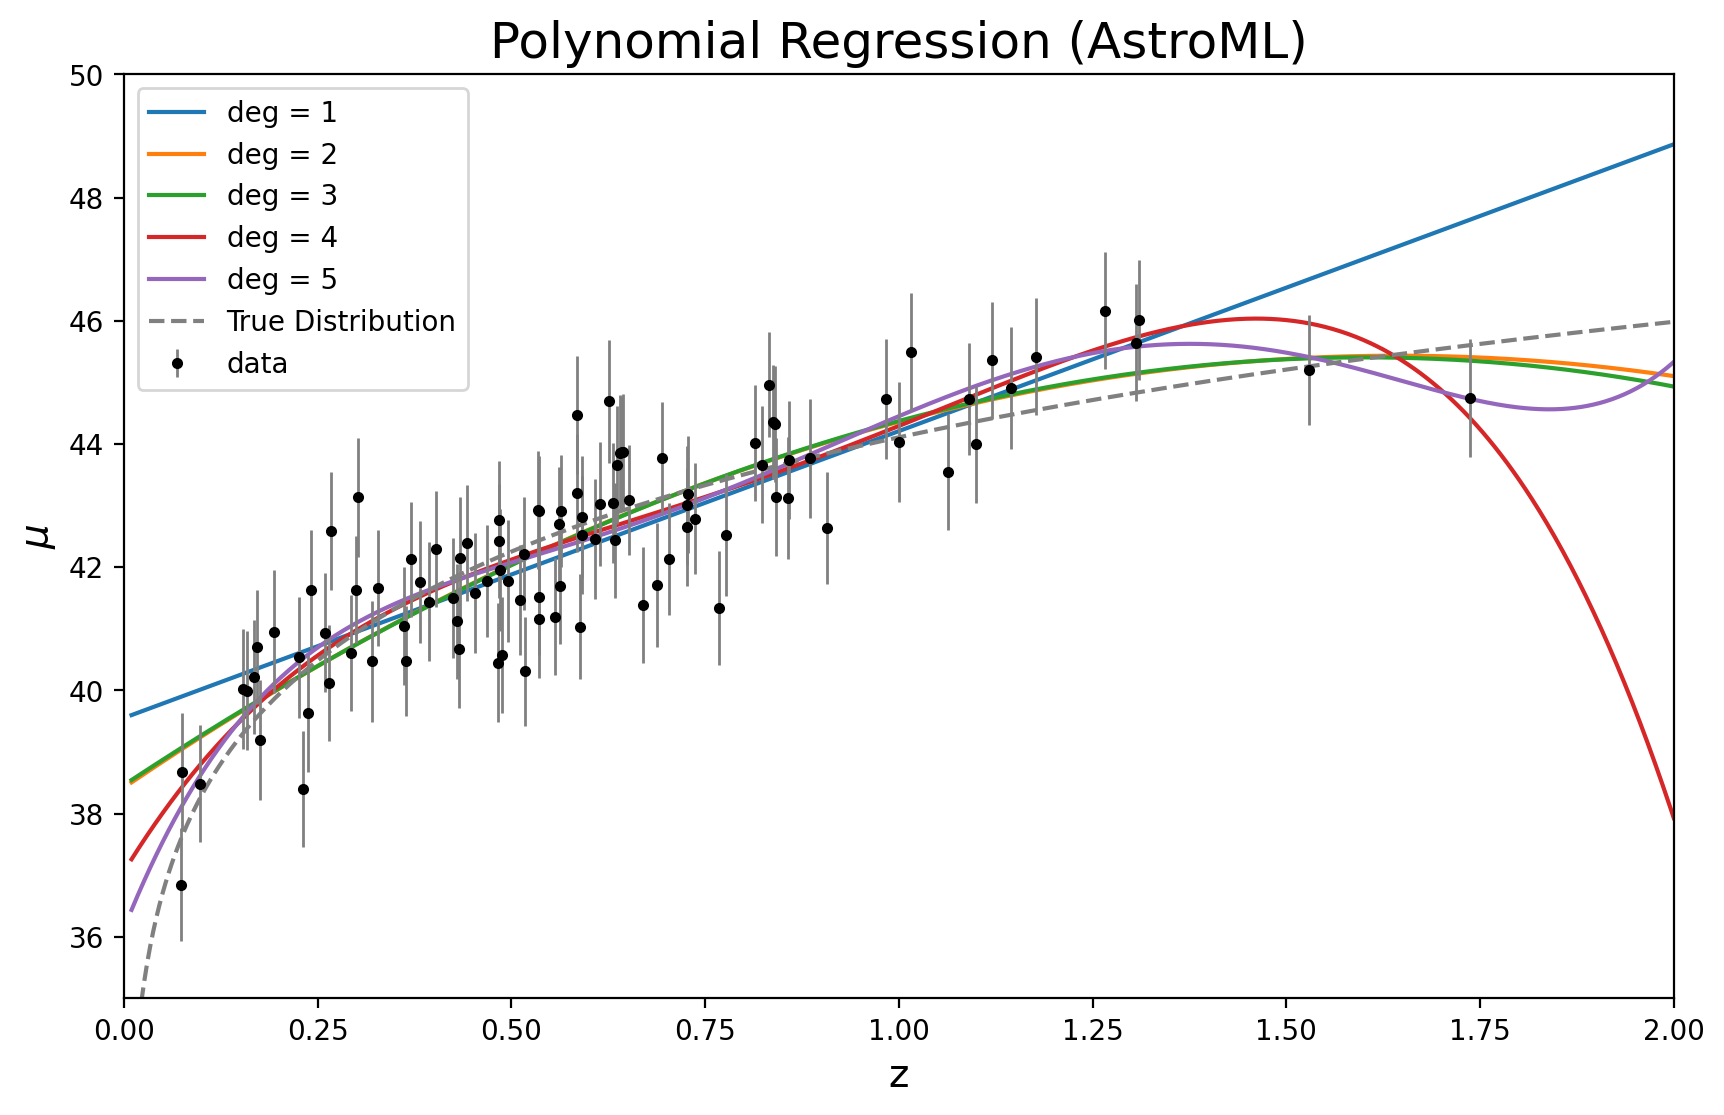

In [11]:
plt.figure(figsize=(10, 6))
for i in range(1,6):
    plt.plot(z, mu_prediction_PR[f'{i}'], label=f'deg = {i}')

plt.errorbar(dataset_sorted[:,0], dataset_sorted[:,1], dmu, fmt='.k', ecolor='gray', lw=1,label='data')
plt.plot(z, mu_true, color='grey', linestyle='--', label='True Distribution')

plt.xlabel("z", fontsize=14)
plt.ylabel("$\mu$", fontsize=14)
plt.title('Polynomial Regression (AstroML)', fontsize=18)
plt.legend(loc='upper left')
plt.xlim(0,2)
plt.ylim(35,50);

It seems that the polynomials that describes the data pretty well are the $2, 3, 4$ degree ones. Then, hihger order polynomials start to overfit the data!

## Kernel Regression

In [12]:
model_KR         = {}
mu_prediction_KR = {}

# Bandwiths to try
hs = np.linspace(0.01, 0.2, 5)

for i in range(len(hs)):
    model_KR = NadarayaWatson(kernel='gaussian', h=hs[i])
    model_KR.fit(dataset_sorted[:,0][:, np.newaxis], dataset_sorted[:,1])

    mu_prediction_KR[f'{i}'] = model_KR.predict(z[:,None])

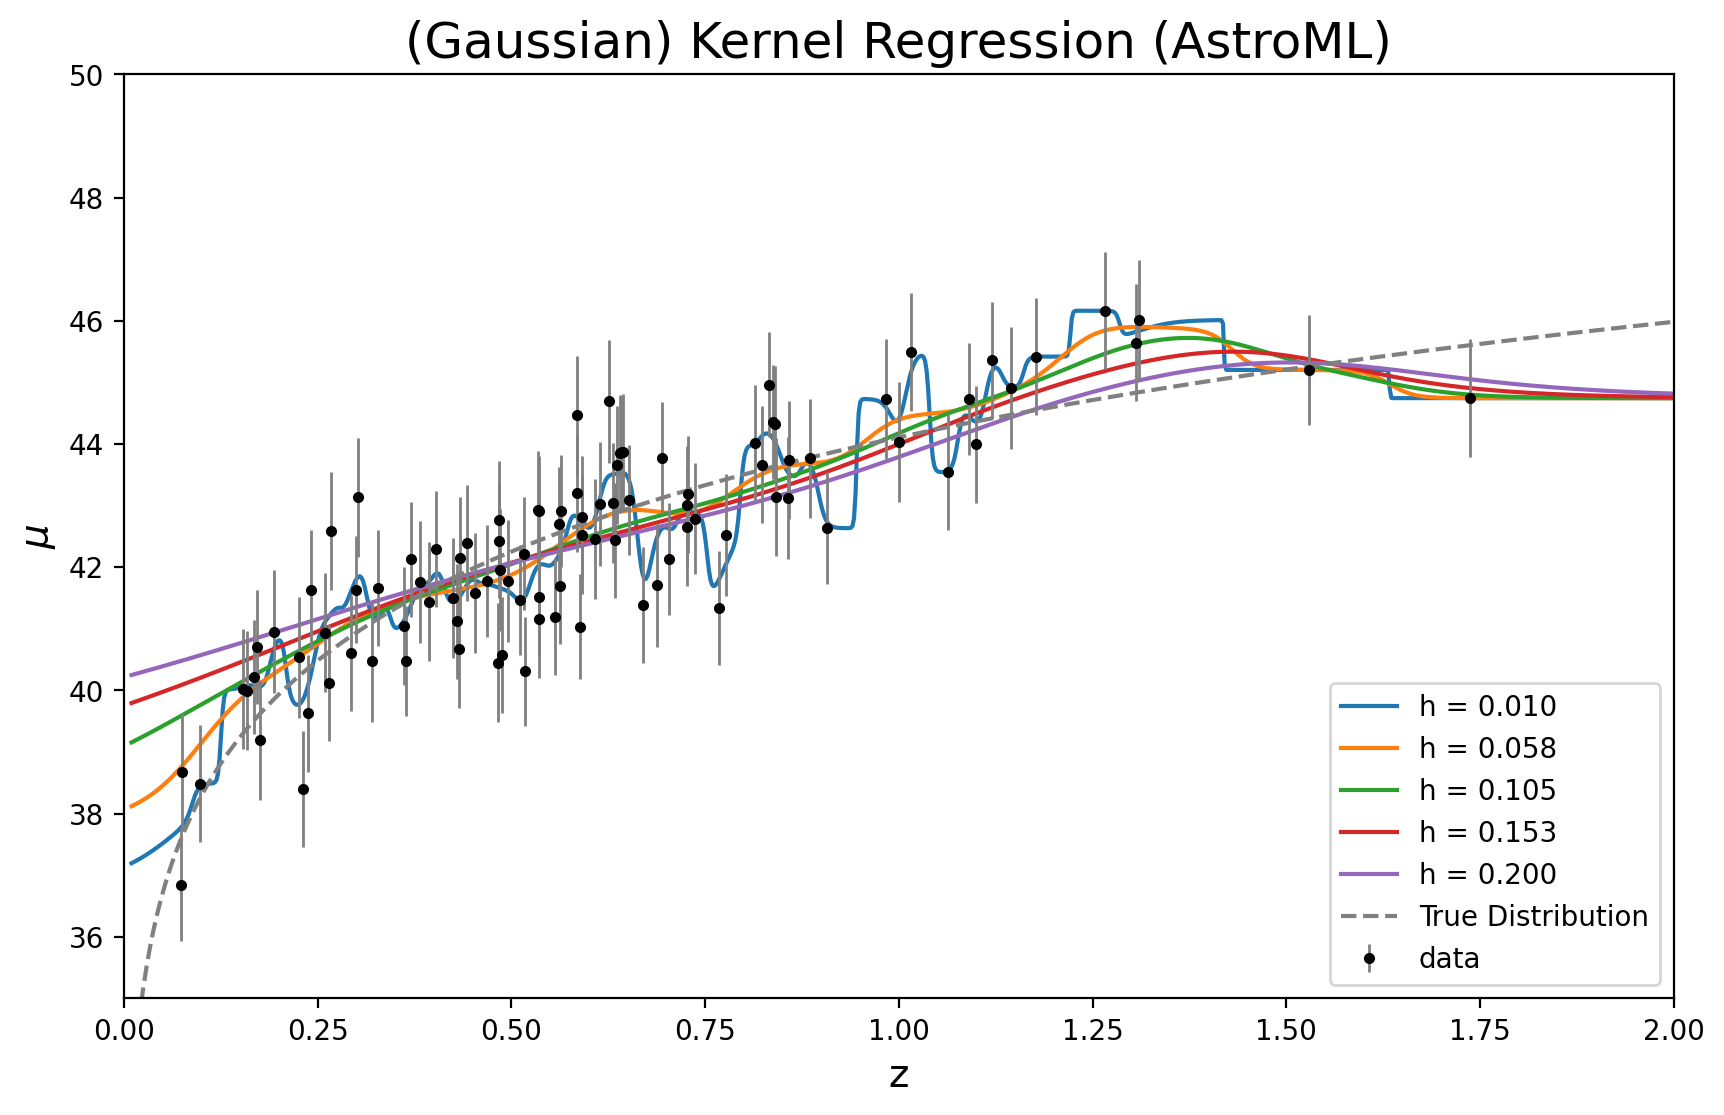

In [13]:
plt.figure(figsize=(10, 6))
for i in range(len(hs)):
    plt.plot(z, mu_prediction_KR[f'{i}'], label=f'h = {hs[i]:.3f}')

plt.errorbar(dataset_sorted[:,0], dataset_sorted[:,1], dmu, fmt='.k', ecolor='gray', lw=1,label='data')
plt.plot(z, mu_true, color='grey', linestyle='--', label='True Distribution')
plt.xlabel("z", fontsize=14)
plt.ylabel("$\mu$", fontsize=14)
plt.title('(Gaussian) Kernel Regression (AstroML)', fontsize=18)
plt.legend(loc='lower right')
plt.xlim(0,2)
plt.ylim(35,50);

## Basis Function Regression

In [14]:
mu_prediction_BFR = {}
for i in np.arange(2,6):
    # mean positions of the i Gaussians in the model
    X_gridtest = np.linspace(0, 2, i)[:, None]

    # widths of these Gaussians
    sigma_test = float((X_gridtest[1]-X_gridtest[0])[0])
    
    model_BFR = BasisFunctionRegression(basis_func='gaussian', mu=X_gridtest, sigma=sigma_test)
    model_BFR.fit(dataset_sorted[:, 0][:, None], dataset_sorted[:, 1], dmu)

    mu_prediction_BFR[f'{i}'] = model_BFR.predict(z[:, None]) 

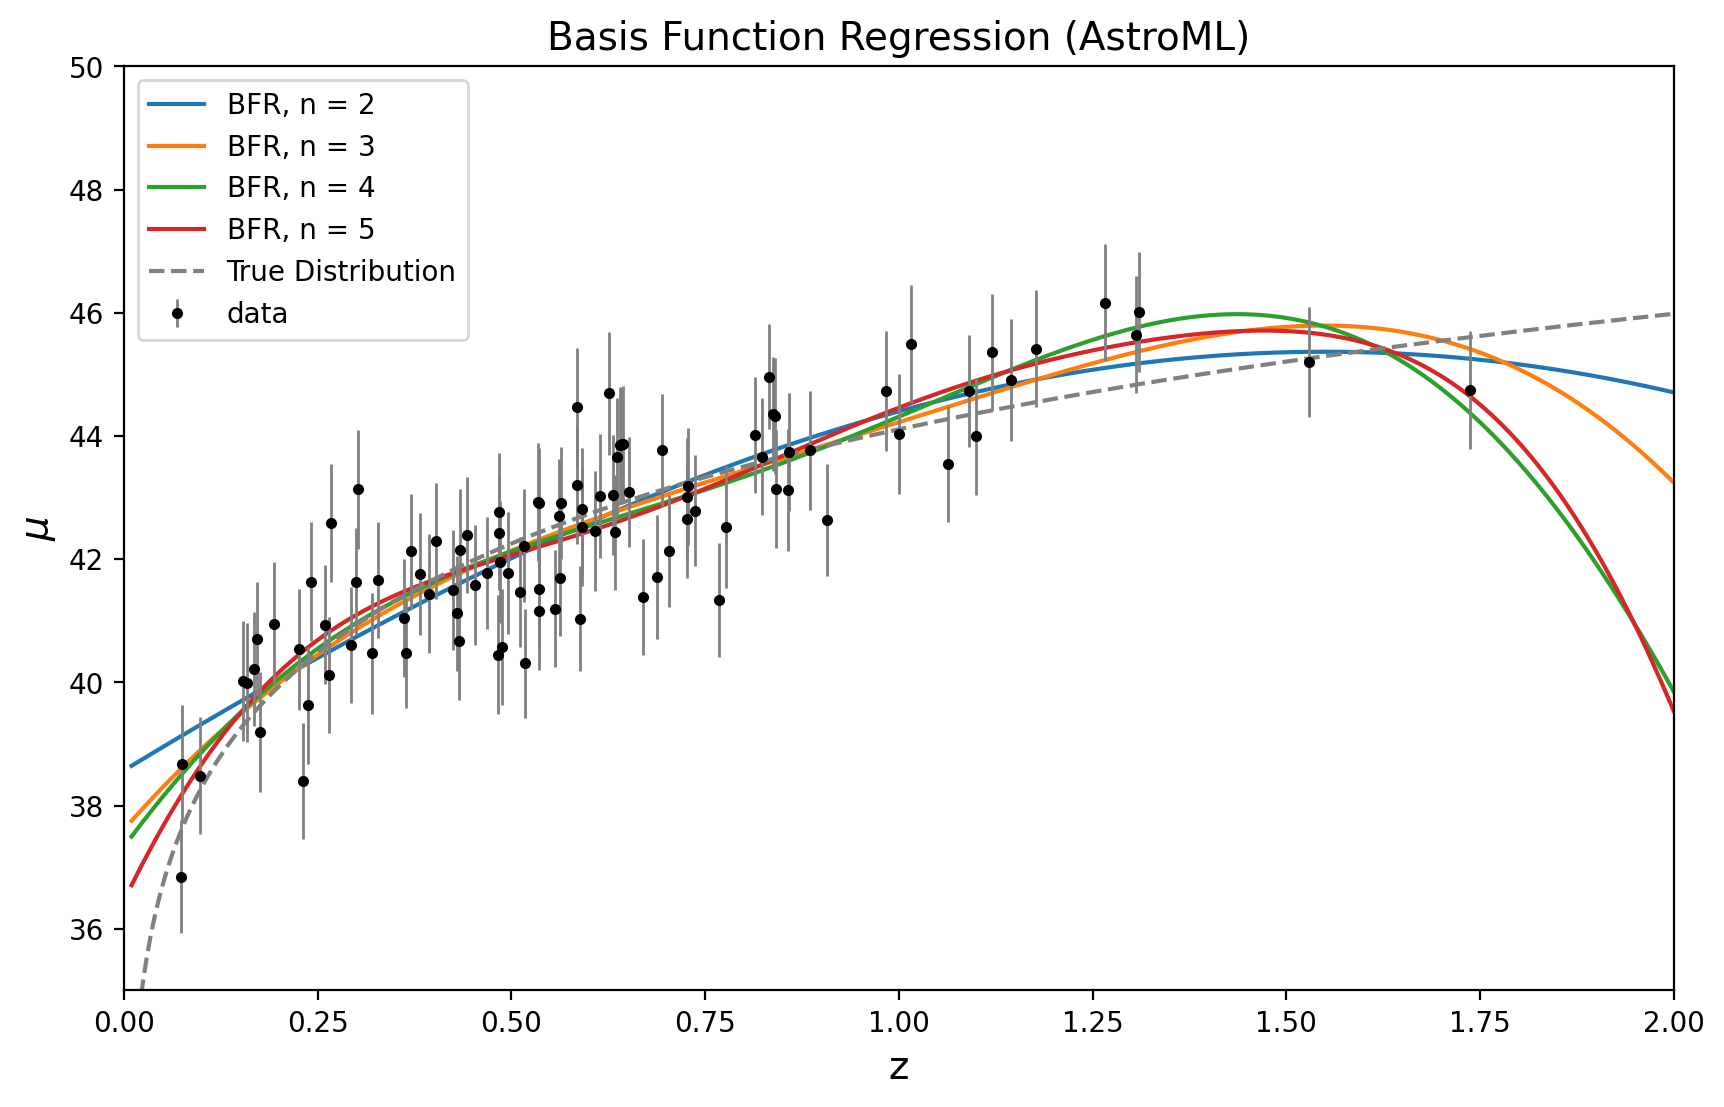

In [15]:
plt.figure(figsize=(10, 6))
for i in np.arange(2,6):
    plt.plot(z, mu_prediction_BFR[f'{i}'], label=f'BFR, n = {i}')

plt.errorbar(dataset_sorted[:,0], dataset_sorted[:,1], dmu, fmt='.k', ecolor='gray', lw=1,label='data')
plt.plot(z, mu_true, color='grey', linestyle='--', label='True Distribution')
plt.xlabel("z", fontsize=14)
plt.ylabel("$\mu$", fontsize=14)
plt.title('Basis Function Regression (AstroML)', fontsize=14)
plt.legend(loc='upper left')
plt.xlim(0,2)
plt.ylim(35,50);

## Cross Validation

In [16]:
# --------------------------------------
# Split the data in a train and a CV set
X_train, X_cv, ydy_train, ydy_cv = train_test_split(dataset_sorted[:, 0], np.array([dataset_sorted[:, 1],dmu]).T, test_size=0.2, random_state=1)  # ydy to have also errors to work with
Y_train, dy_train = ydy_train.T
Y_cv,dy_cv = ydy_cv.T

In [17]:
full_dataset = np.array((z_sample, mu_sample, dmu)).T

In [18]:
# --------------------------------
# Function that computes the error
def error(X, y, regressor):
    return np.sqrt(np.sum((y-regressor.predict(X))**2)/len(X))

def cv_train_error(X, y, dy, regressor_type, k):
    kf = KFold(n_splits=k, shuffle=True, random_state=10)

    train_error = []
    cv_error   = []
    for train_index, cv_index in kf.split(X):
        regressor_type.fit(X[train_index], y[train_index], dy[train_index])

        train_error.append(error(X[train_index], y[train_index], regressor_type))
        cv_error.append(error(X[cv_index], y[cv_index], regressor_type))

    return np.median(train_error), np.median(cv_error)

### Polynomial Regression

In [21]:
cv_error_PR   = []
train_error_PR = []

for degree in range(1,10):
    regressor_type = PolynomialRegression(degree)
    train_error_i, cv_error_i = cv_train_error(full_dataset[:,0][:,None], full_dataset[:,1], full_dataset[:,2], regressor_type, 11)

    cv_error_PR.append(cv_error_i)
    train_error_PR.append(train_error_i)

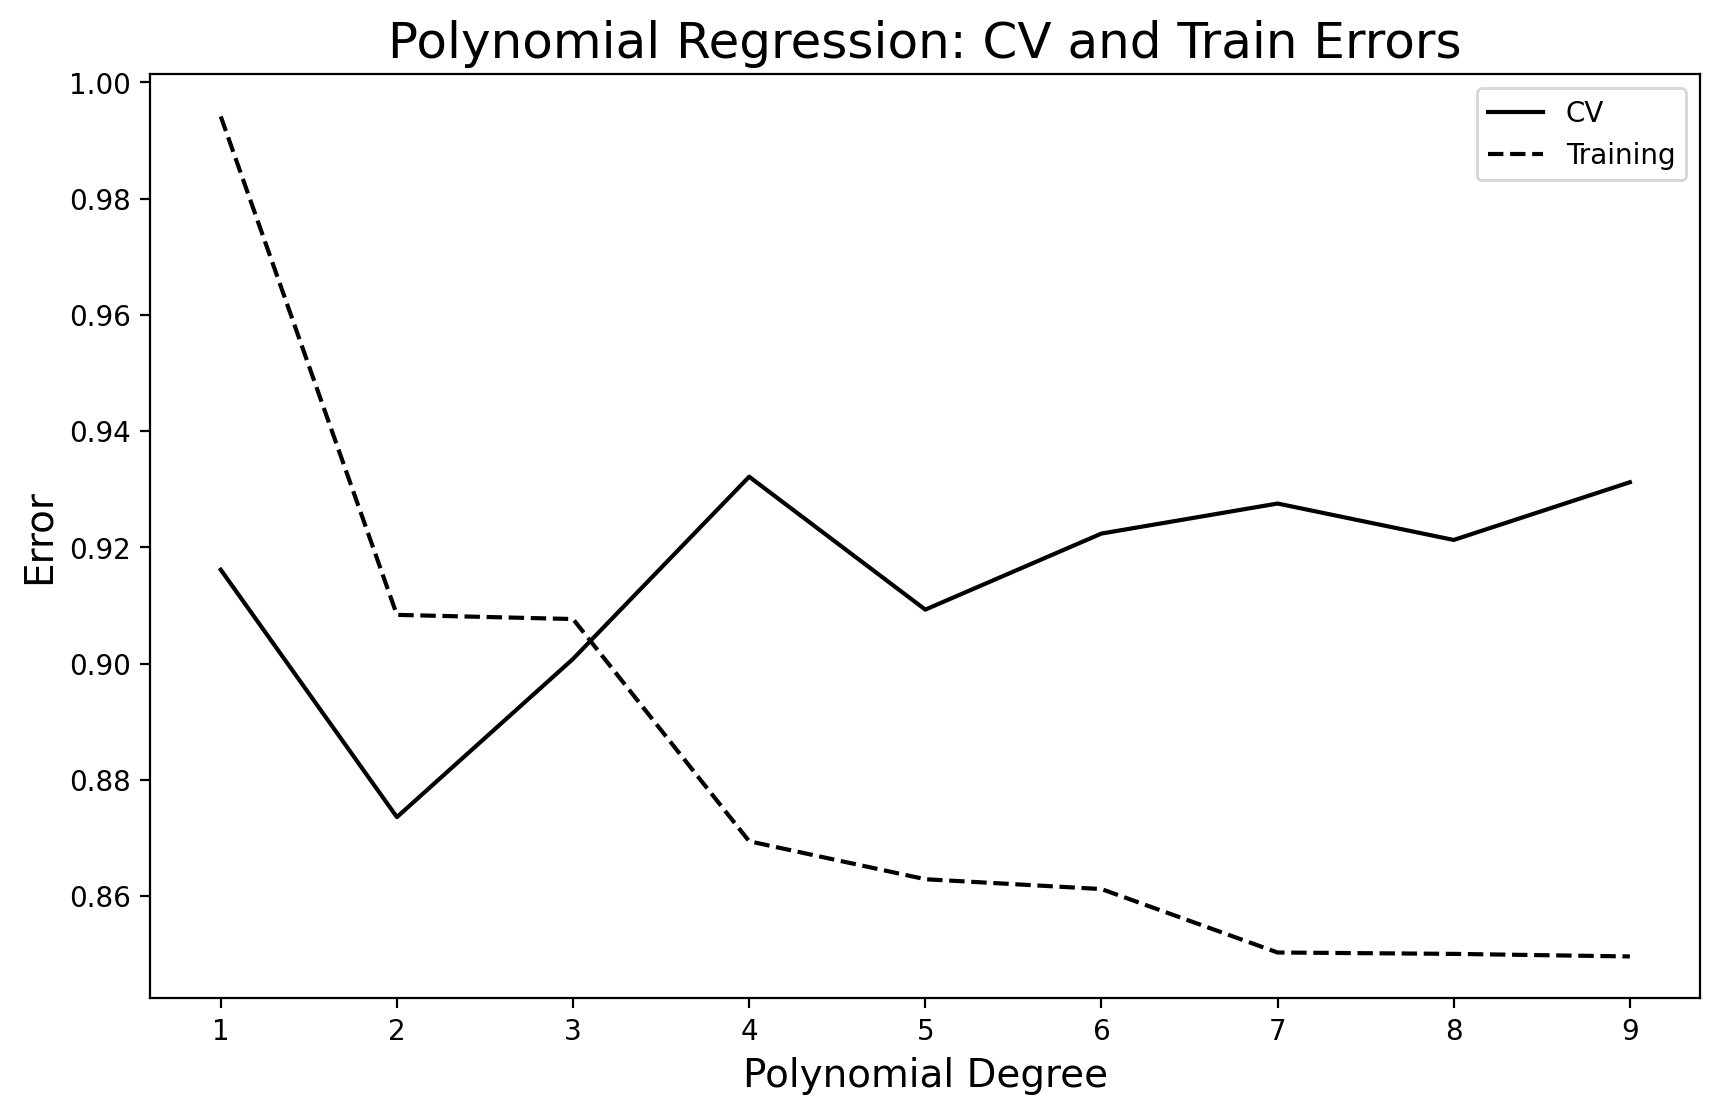

In [22]:
plt.figure(figsize=(10, 6))
plt.plot(np.arange(1, len(cv_error_PR)+1),   cv_error_PR, color='Black', label='CV')
plt.plot(np.arange(1, len(train_error_PR)+1), train_error_PR, color='Black', linestyle='dashed', label='Training')
plt.xlabel('Polynomial Degree', fontsize=14)
plt.ylabel('Error', fontsize=14)
plt.title('Polynomial Regression: CV and Train Errors', fontsize=18)
plt.legend(loc='upper right');

In [23]:
print("best component:", np.argmin(cv_error_PR) + 1, ", with error value:", np.min(cv_error_PR))

best component: 2 , with error value: 0.8736006812023689


### Kernel Regression

In [24]:
cv_error_KR   = []
train_error_KR = []

hs = np.linspace(0.01, 0.2, 5)

for i in range(0,len(hs)):
    regressor_type = NadarayaWatson(kernel='gaussian', h=hs[i])
    train_error_i, cv_error_i = cv_train_error(full_dataset[:,0][:,None], full_dataset[:,1], full_dataset[:,2], regressor_type, 8)
    cv_error_KR.append(cv_error_i)
    train_error_KR.append(train_error_i)

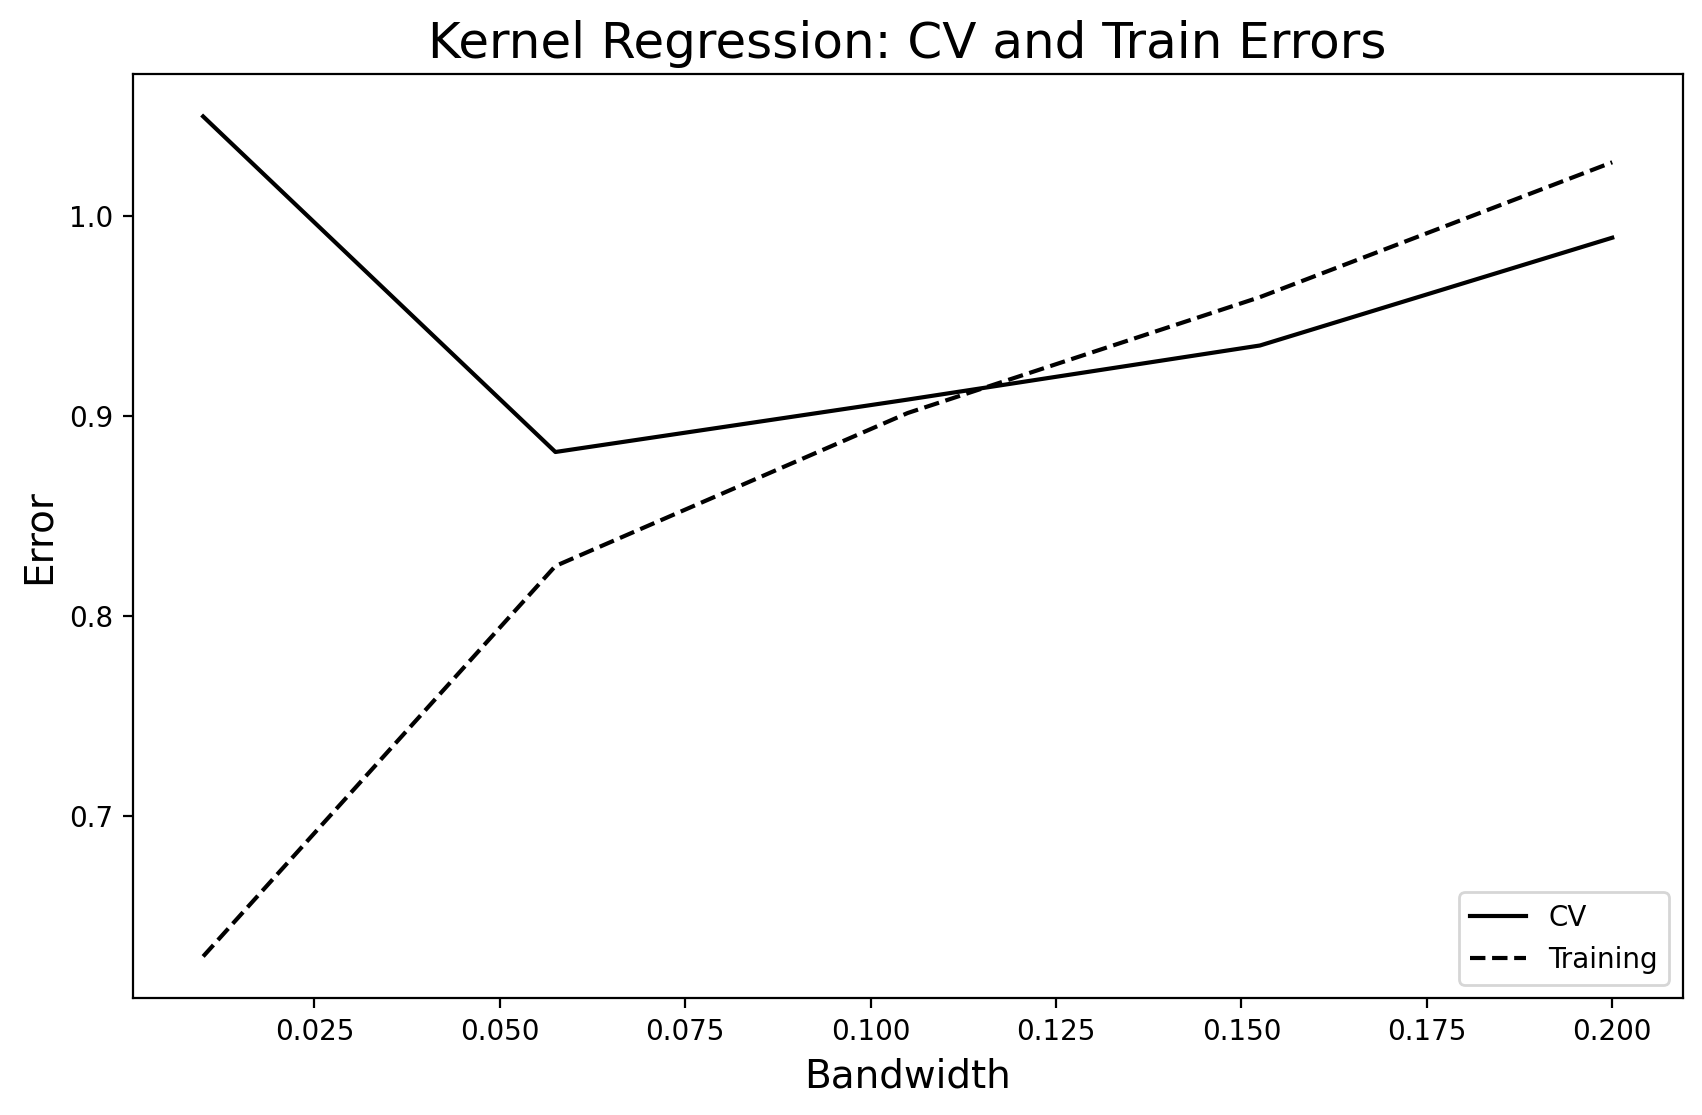

In [25]:
plt.figure(figsize=(10, 6))
plt.plot(hs,   cv_error_KR, color='Black', label='CV')
plt.plot(hs, train_error_KR, color='Black', linestyle='dashed', label='Training')
plt.xlabel('Bandwidth', fontsize=14)
plt.ylabel('Error', fontsize=14)
plt.title('Kernel Regression: CV and Train Errors', fontsize=18)
plt.legend(loc='lower right');

In [26]:
print("best component h:",hs[np.argmin(cv_error_KR)], ", with error value:", np.min(cv_error_KR))

best component h: 0.0575 , with error value: 0.8819542467146612


### Basis Function Regression

In [27]:
cv_error_BFR    = []
train_error_BFR = []
    
for i in np.arange(2, 6): 

    # mean positions of the i Gaussians in the model
    X_gridtest = np.linspace(0, 2, i)[:, None]

    # widths of these Gaussians
    sigma_test = float((X_gridtest[1]-X_gridtest[0])[0])
    
    regressor_type = BasisFunctionRegression(basis_func='gaussian', mu=X_gridtest, sigma=sigma_test)
 
    train_error_i, cv_error_i = cv_train_error(full_dataset[:, 0][:, None], full_dataset[:, 1], full_dataset[:, 2], regressor_type, 11)
    cv_error_BFR.append(cv_error_i)
    train_error_BFR.append(train_error_i)

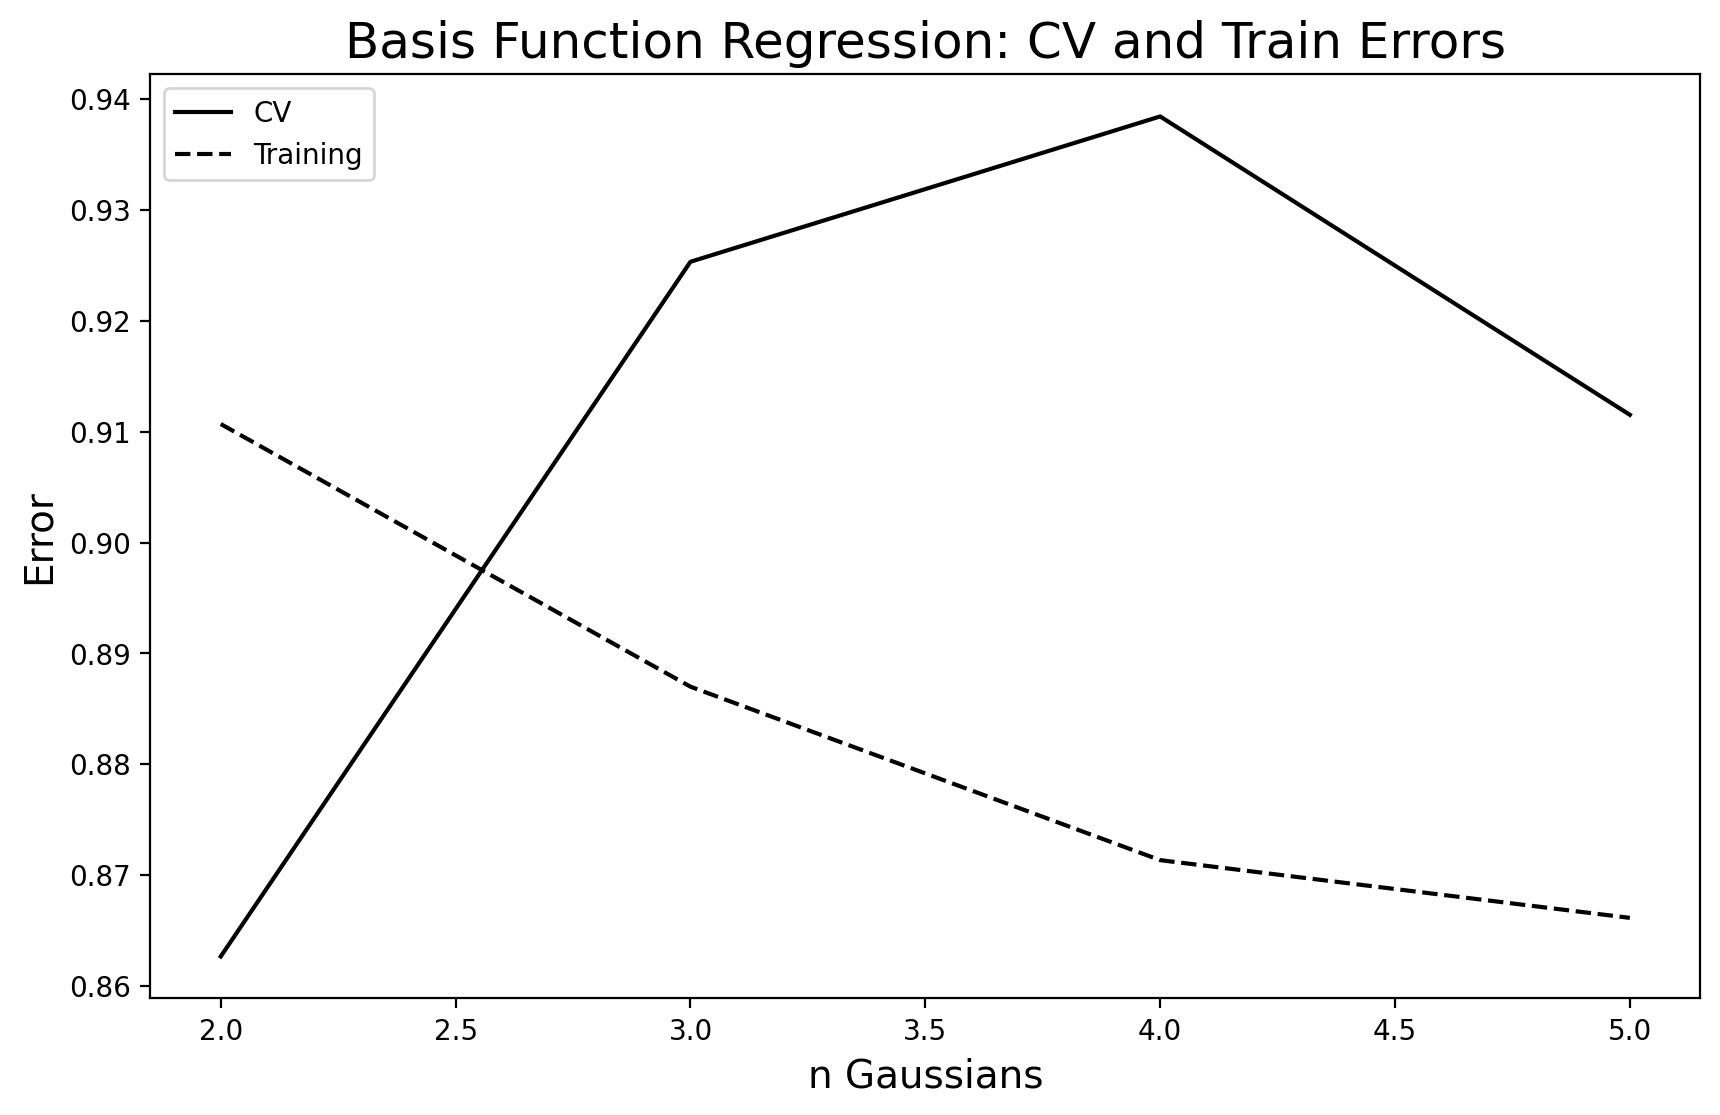

In [28]:
plt.figure(figsize=(10, 6))
plt.plot(np.arange(2, 6), cv_error_BFR, color='Black', label='CV')
plt.plot(np.arange(2,6), train_error_BFR, color='Black', linestyle='dashed', label='Training')
plt.xlabel('n Gaussians', fontsize=14)
plt.ylabel('Error', fontsize=14)
plt.title('Basis Function Regression: CV and Train Errors', fontsize=18)
plt.legend(loc='upper left');

In [29]:
print("Best component n_gauss:",np.arange(1,25)[1::5][np.argmin(cv_error_BFR)], ", with error value:", np.min(cv_error_BFR))

Best component n_gauss: 2 , with error value: 0.8626607438766614


## Visualize our 'best' models
### Polynomial Regression

In [30]:
best_pol_reg = PolynomialRegression(np.argmin(cv_error_PR) + 1)
best_pol_reg.fit(dataset_sorted[:,0][:,None], dataset_sorted[:,1], dmu)
coeffs = best_pol_reg.coef_

best_mu_pr = best_pol_reg.predict(z[:,None])

### Kernel Regression

In [31]:
best_ker_reg = NadarayaWatson(kernel='gaussian', h=hs[np.argmin(cv_error_KR)])
best_ker_reg.fit(dataset_sorted[:,0][:, np.newaxis], dataset_sorted[:,1])

best_mu_kr = best_ker_reg.predict(z[:,None])

### Basis Function Regression

In [32]:
best_mu_BFR = mu_prediction_BFR[f'{np.argmin(cv_error_BFR)+2}']

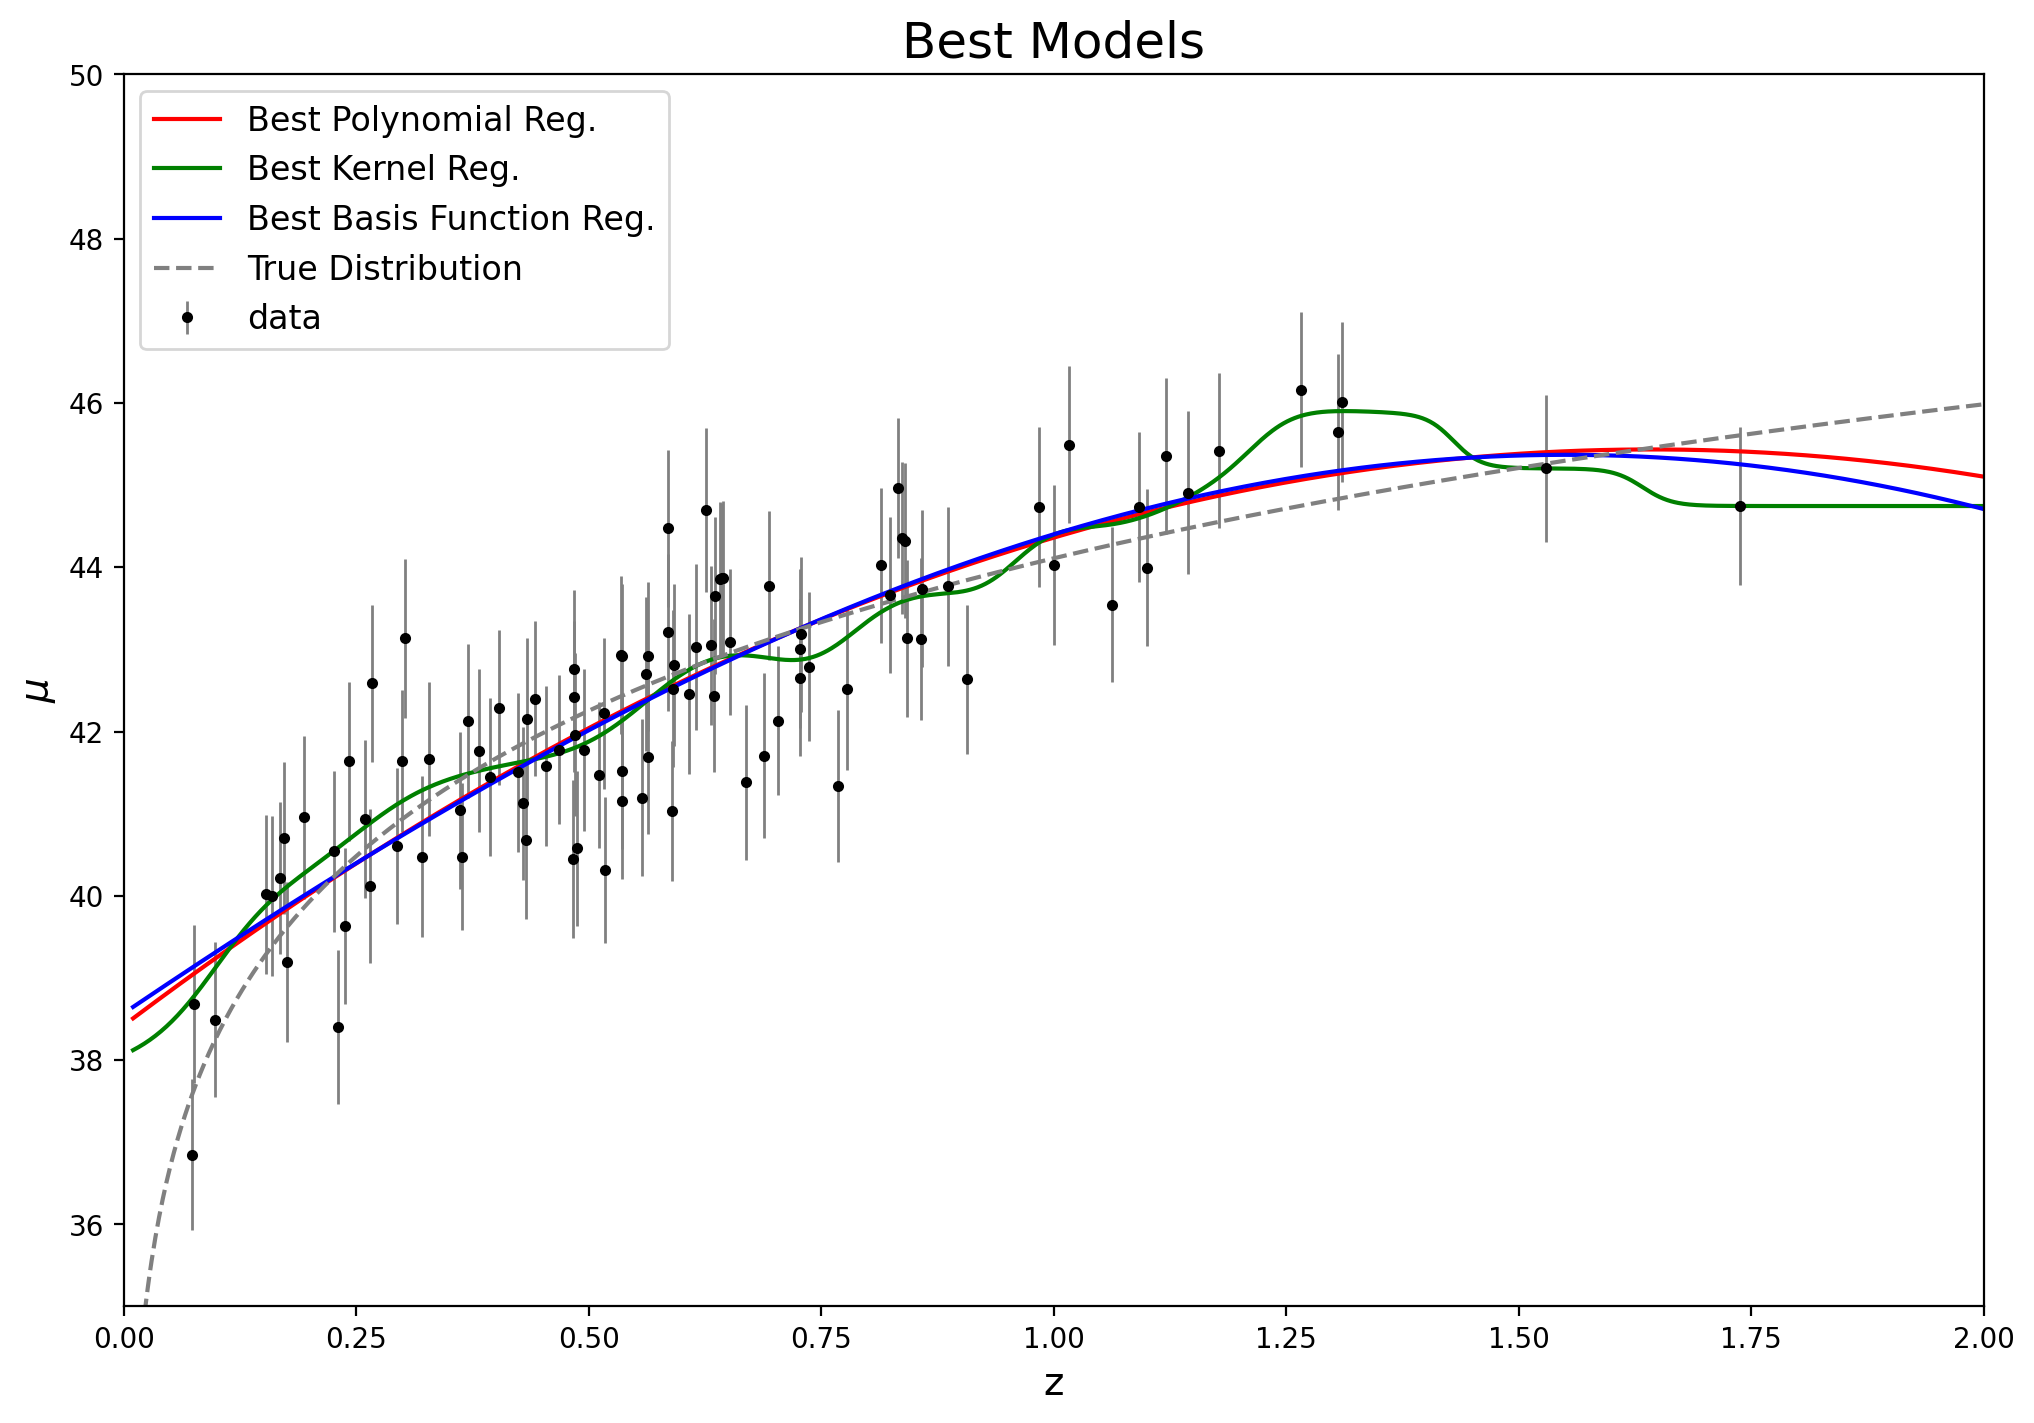

In [34]:
plt.figure(figsize=(12,8))
plt.errorbar(dataset_sorted[:,0], dataset_sorted[:,1], dmu, fmt='.k', ecolor='gray', lw=1,label='data')
plt.plot(z, best_mu_pr, color='red', label=f'Best Polynomial Reg.')
plt.plot(z, best_mu_kr, color='green', label=f'Best Kernel Reg.')
plt.plot(z, best_mu_BFR, color='blue', label=f'Best Basis Function Reg.')
plt.plot(z, mu_true, color='grey', linestyle='--', label='True Distribution')

plt.xlabel("z", fontsize=14)
plt.ylabel("$\mu$", fontsize=14)
plt.title('Best Models', fontsize=18)
plt.legend(loc='upper left', fontsize=12)
plt.xlim(0,2)
plt.ylim(35,50);

## Learning Curves

In [35]:
z_sample_1, mu_sample_1, dmu_1 = generate_mu_z(1000, random_state=1234)

In [38]:
# stacking the arrays
new_dataset = np.array((z_sample_1, mu_sample_1, dmu_1)).T

In [39]:
X_train, X_test, ydy_train, ydy_test = train_test_split(new_dataset[:, 0], np.array((new_dataset[:, 1], new_dataset[:, 2])).T, test_size=0.33, random_state=42)
Y_train, dy_train = ydy_train.T
Y_test,  dy_test = ydy_test.T

### Polynomial Regression

In [41]:
N_cv_error_PR   = []
N_train_error_PR = []

for N in range(10, 1000, 10):
    pol_reg = PolynomialRegression(np.argmin(cv_error_PR)+1)
    pol_reg.fit(X_train[:N][:,None], Y_train[:N], dy_train[:N])
    
    N_train_error_PR.append(error(X_train[:N][:,None], Y_train[:N], pol_reg))
    N_cv_error_PR.append(error(X_test[:,None], Y_test, pol_reg))

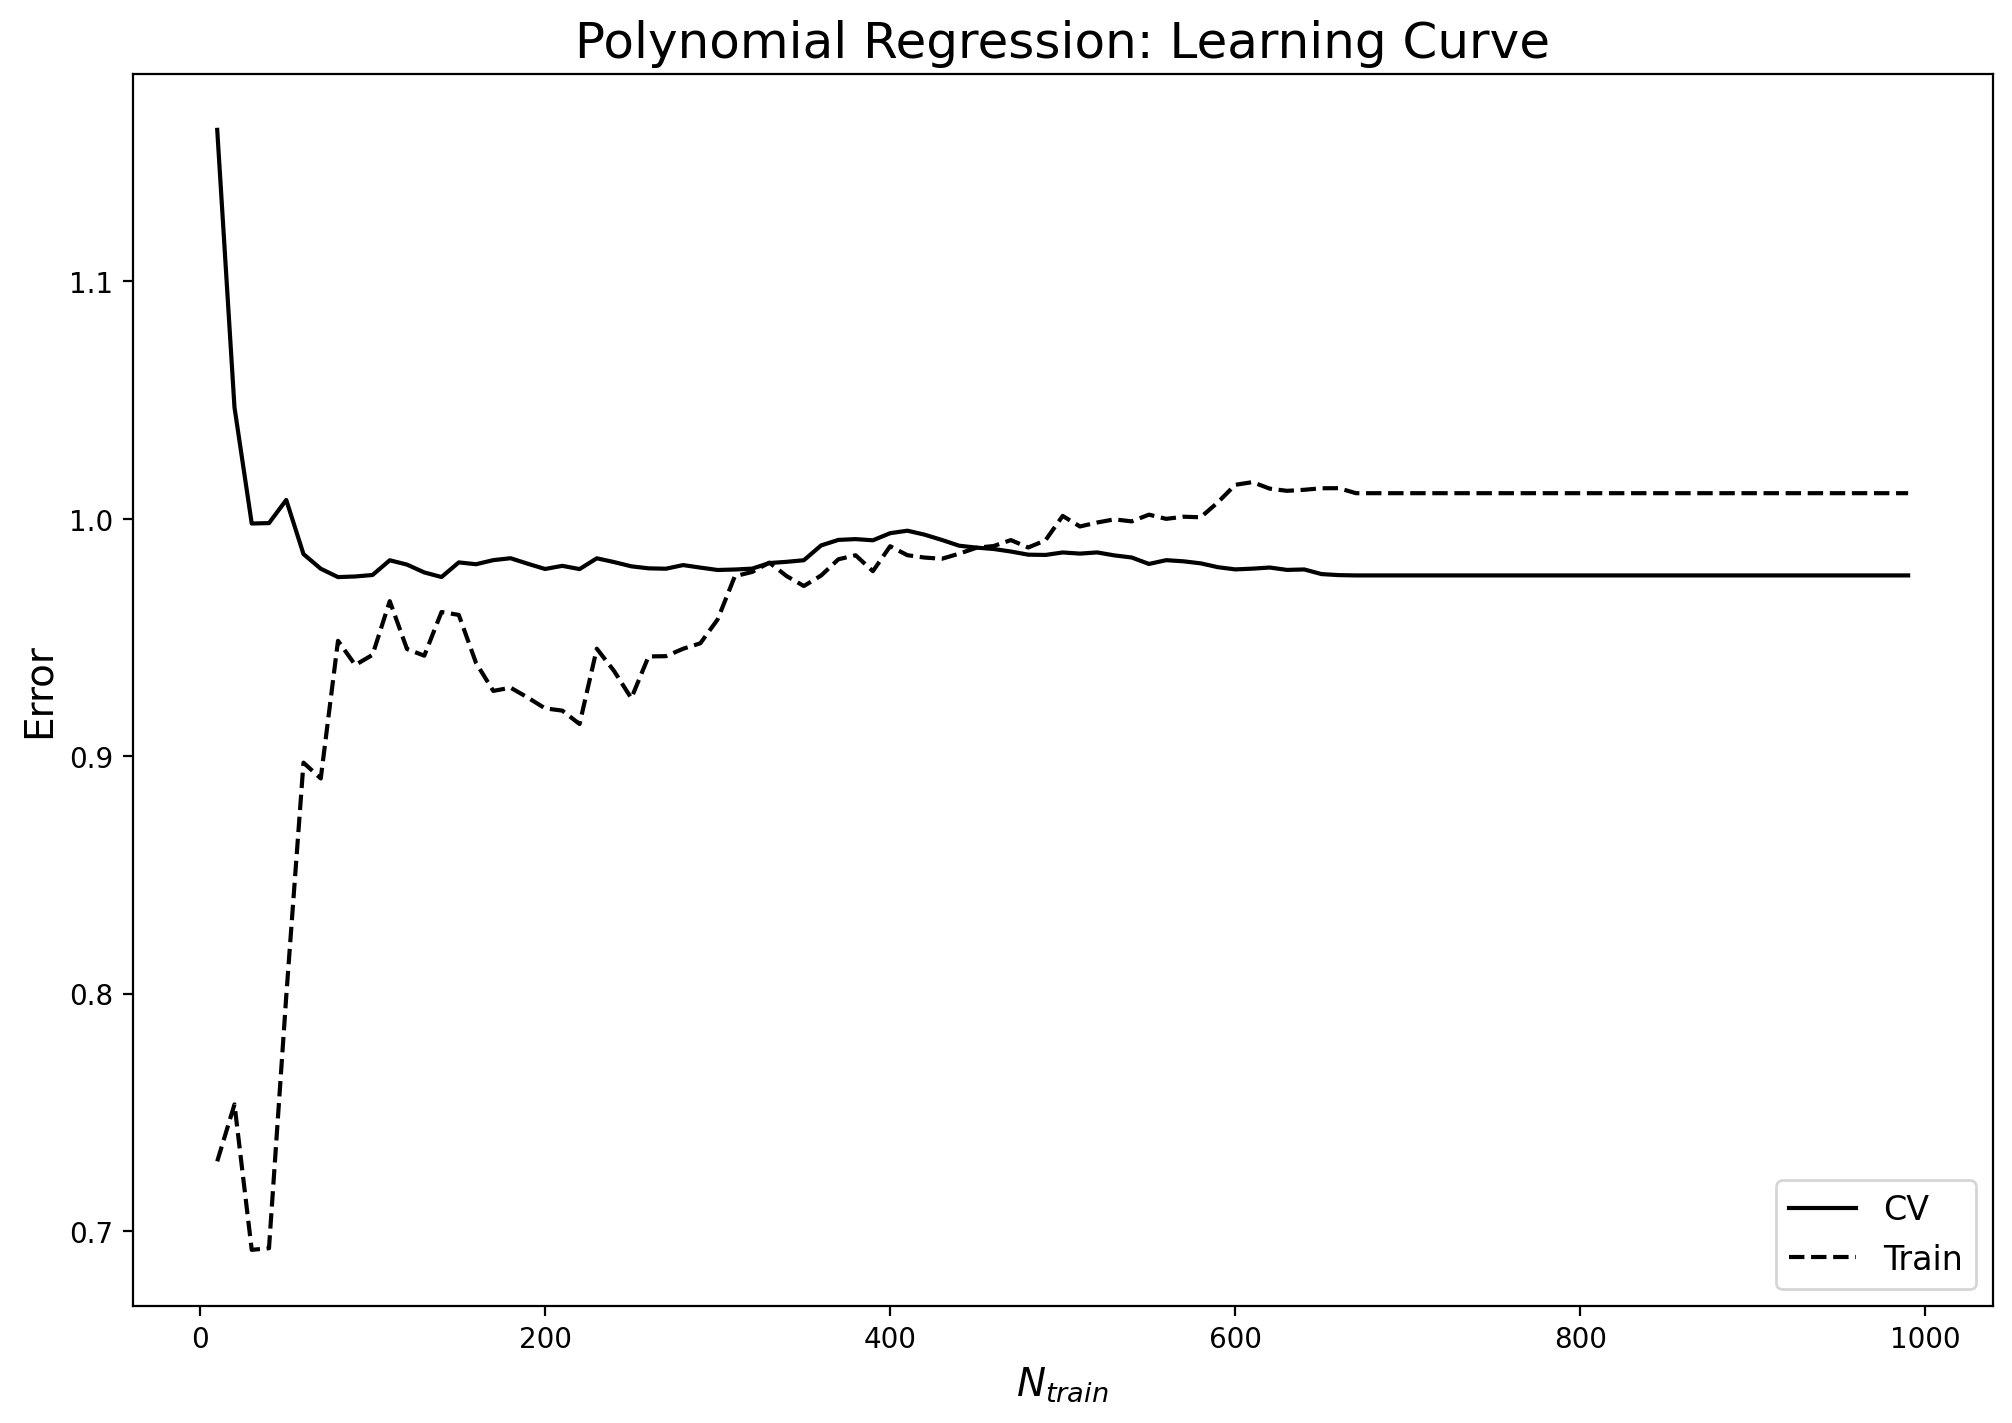

In [42]:
plt.figure(figsize=(12,8))
plt.plot(range(10,1000,10), N_cv_error_PR, color='Black', label='CV')
plt.plot(range(10,1000,10), N_train_error_PR, color='Black', linestyle='dashed', label='Train')
plt.xlabel(r'$N_{train}$', fontsize=14)
plt.ylabel('Error', fontsize=14)
plt.title('Polynomial Regression: Learning Curve', fontsize=18)
plt.legend(loc='lower right', fontsize=12);

### Kernel Regression

In [43]:
N_cv_error_KR   = []
N_train_error_KR = []

for N in range(10, 1000, 10):
    ker_reg = NadarayaWatson(kernel='gaussian',h=hs[np.argmin(cv_error_KR)])
    ker_reg.fit(X_train[:N][:,None], Y_train[:N], dy_train[:N])
        
    N_train_error_KR.append(error(X_train[:N][:,None], Y_train[:N], ker_reg))
    N_cv_error_KR.append(error(X_test[:,None], Y_test, ker_reg))

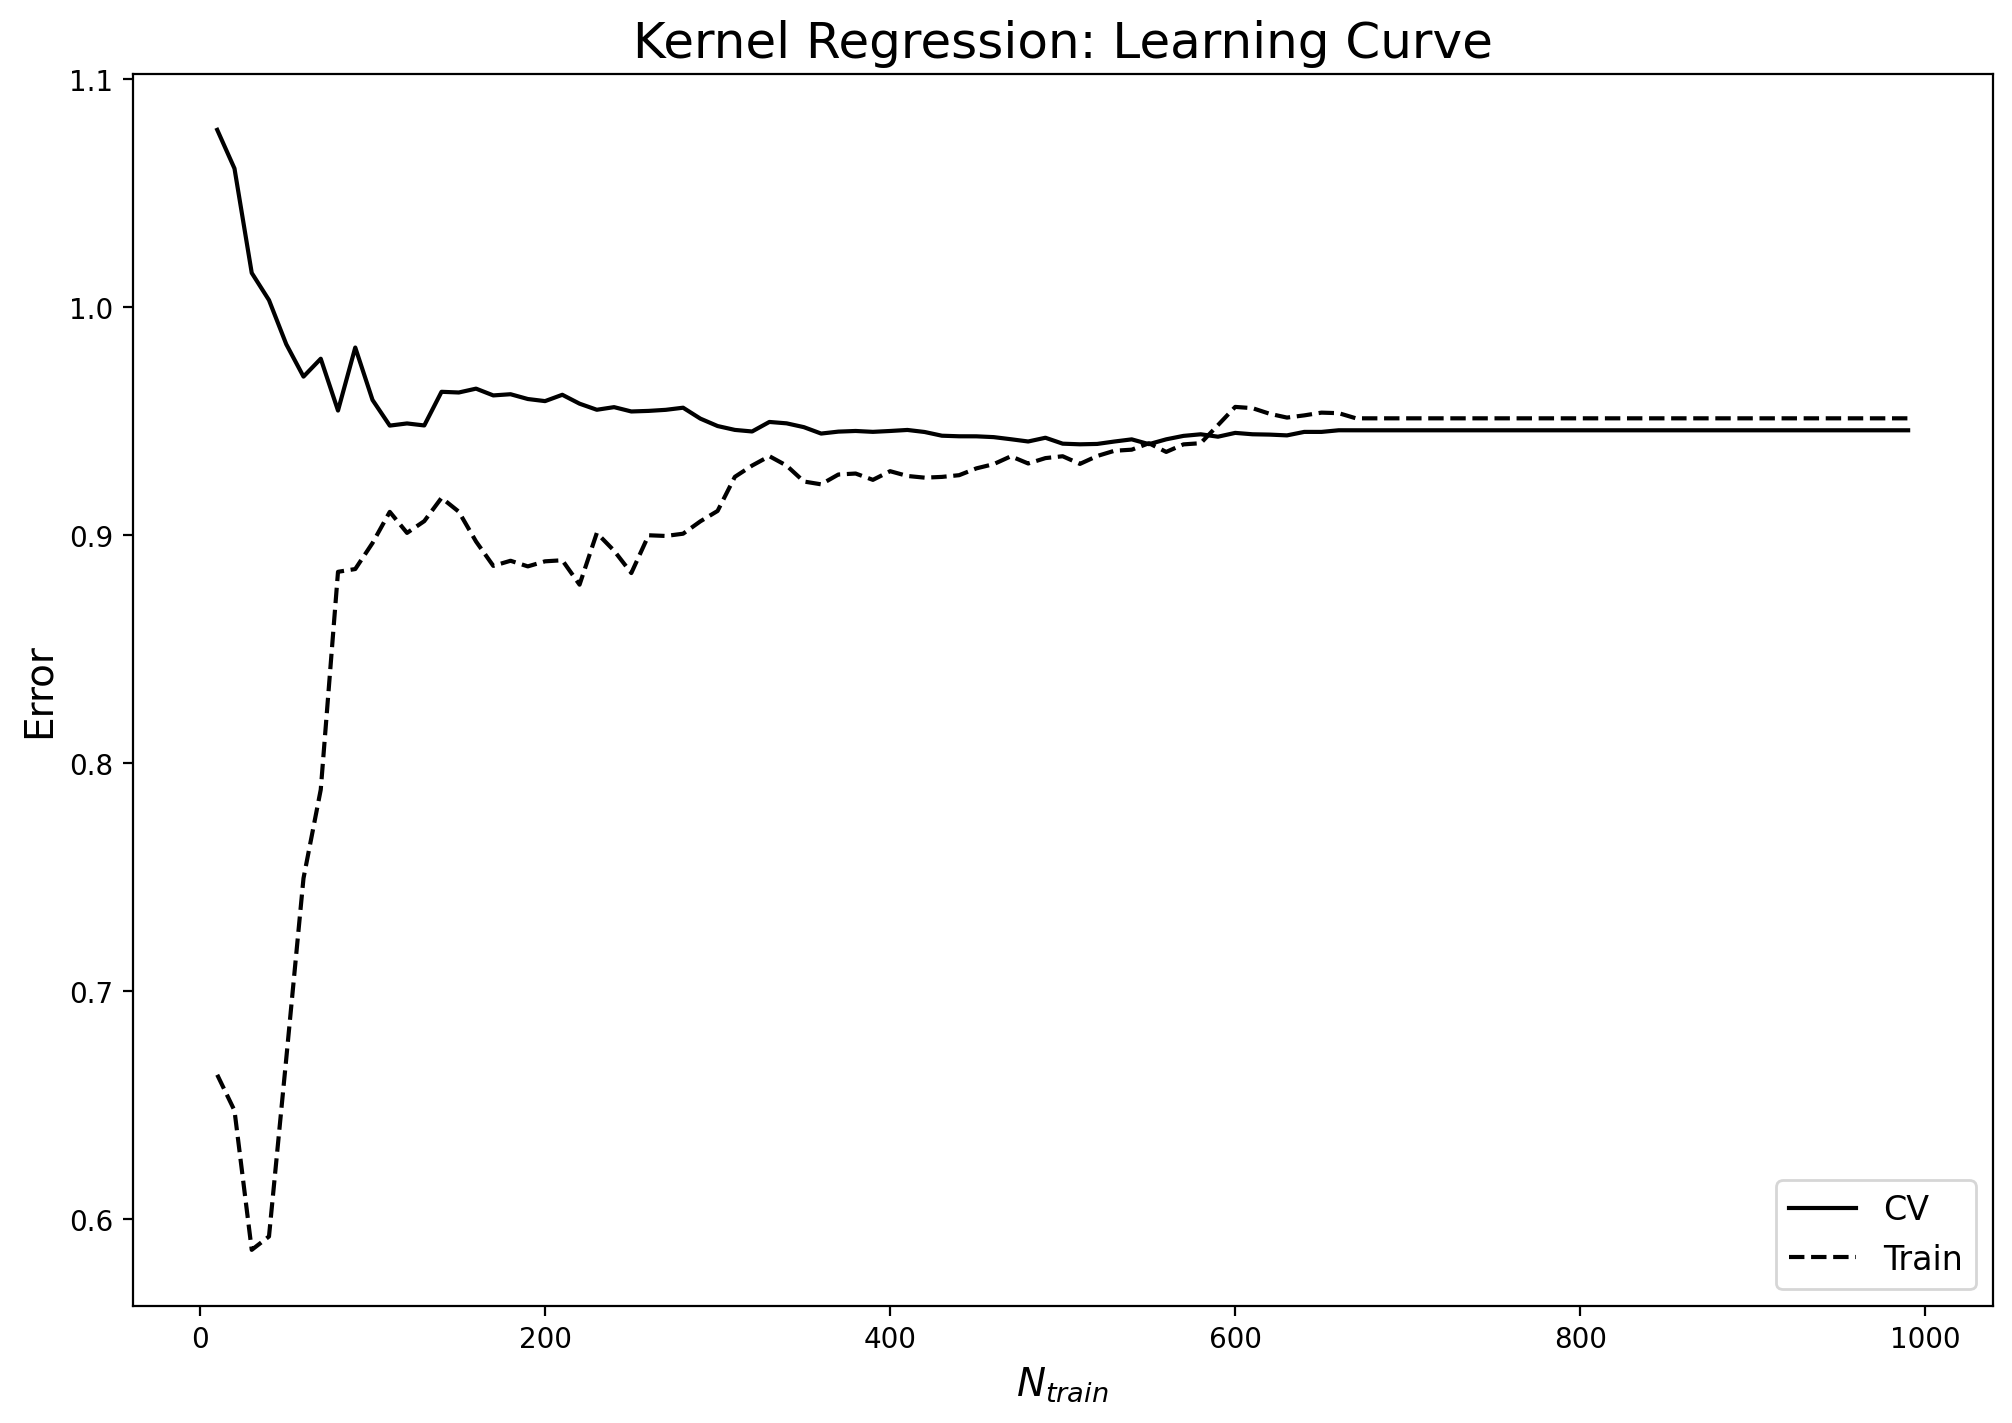

In [44]:
plt.figure(figsize=(12,8))
plt.plot(range(10,1000,10), N_cv_error_KR, color='Black',   label='CV')
plt.plot(range(10,1000,10), N_train_error_KR, color='Black', linestyle='dashed', label='Train')
plt.xlabel(r'$N_{train}$', fontsize=14)
plt.ylabel('Error', fontsize=14)
plt.title('Kernel Regression: Learning Curve', fontsize=18)
plt.legend(loc='lower right', fontsize=12);

### Basis Function Regression

In [45]:
N_cv_error_BFR    = []
N_train_error_BFR = []

for N in range(10, 1000, 10):
    X_gridtest = np.linspace(0, 2, np.arange(1,25)[1::5][np.argmin(cv_error_BFR)])[:,None]
    sigma_test = float((X_gridtest[1]-X_gridtest[0])[0])
    
    bf_reg = BasisFunctionRegression(basis_func='gaussian', mu=X_gridtest, sigma=sigma_test)
    bf_reg.fit(X_train[:N][:,None], Y_train[:N], dy_train[:N])
        
    N_train_error_BFR.append(error(X_train[:N][:,None], Y_train[:N], bf_reg))
    N_cv_error_BFR.append(error(X_test[:,None], Y_test, bf_reg))

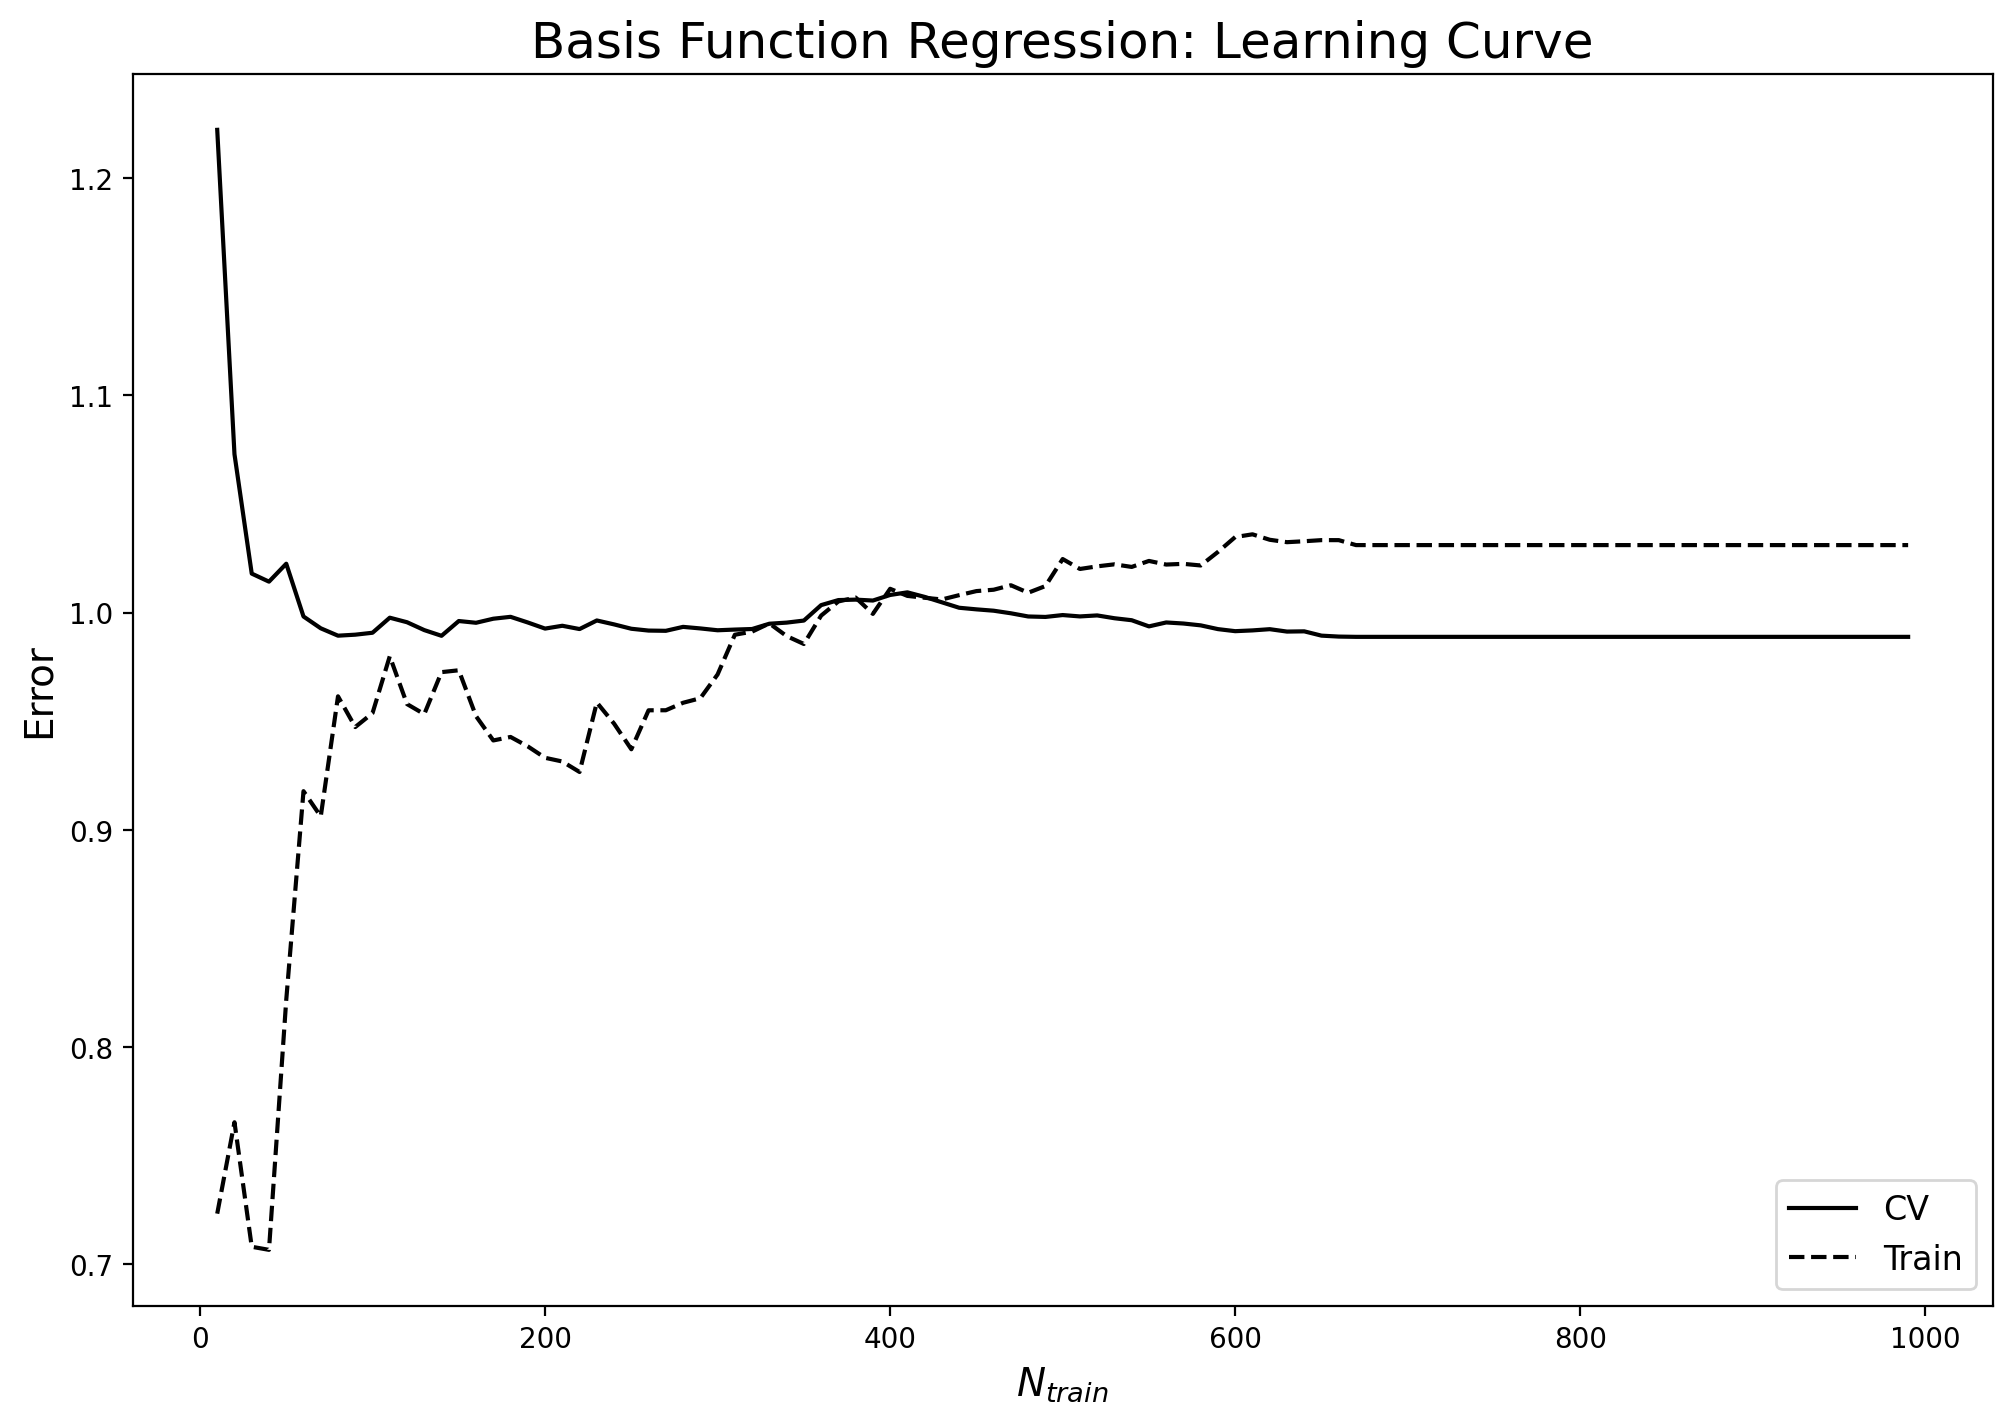

In [46]:
plt.figure(figsize=(12,8))
plt.plot(range(10,1000,10), N_cv_error_BFR, color='Black',   label='CV')
plt.plot(range(10,1000,10), N_train_error_BFR, color='Black', linestyle='dashed', label='Train')
plt.xlabel(r'$N_{train}$', fontsize=14)
plt.ylabel('Error', fontsize=14)
plt.title('Basis Function Regression: Learning Curve', fontsize=18)
plt.legend(loc='lower right', fontsize=12);